In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor

In [120]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [121]:
# Find and visualize missing values.
with_None = np.array([1, None, 2])
with_NaN = np.array([1, np.nan, 2])

In [122]:
with_NaN.sum()

nan

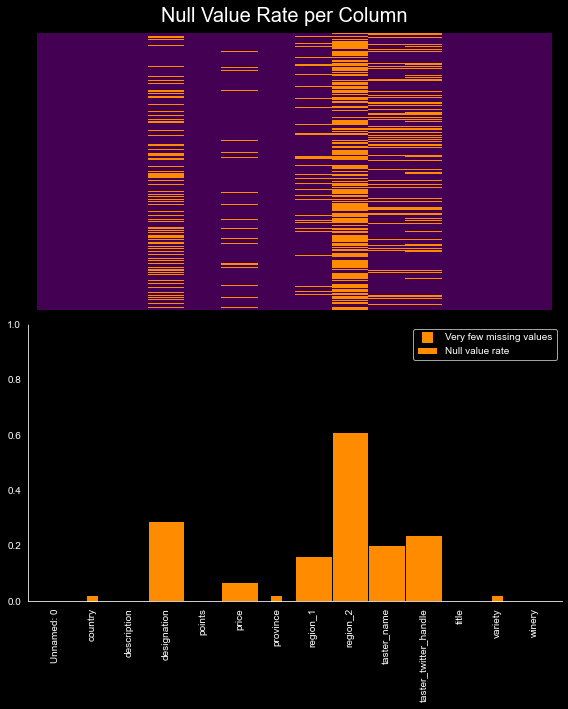

In [123]:
def nullscan(df_check, save=False):
    # a df with the same size of the original dataframe, containing True in cells containing NUll values, and False in all the other cells.
    df_nulls = df_check.isna()
    # a series containing the sum of all values within a column having the column names as indices. True is interpreted as 1 and False is interpreted as 0 
    nulls_per_col = df_nulls.sum(axis=0)
    # the rate makes it way more interpretable:
    nulls_per_col /= len(df_check.index)

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
        vir = matplotlib.cm.get_cmap('viridis')
        colormap = matplotlib.colors.ListedColormap([vir(0), 'darkorange'])
        sns.heatmap(df_check.isnull(), cmap=colormap, cbar=False, yticklabels=False, ax=ax1)

        nulls_per_col.plot(kind='bar', color='darkorange', x=nulls_per_col.values, 
                           y=nulls_per_col.index, ax=ax2, width=1, linewidth=1, 
                           edgecolor='black', align='edge', label='Null value rate')
        
        ax2.set_ylim((0,1))
        # centered labels
        labels=df_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
    
        # hide spines:
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')

        # workaround to visualize very small amounts of null values per column.
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='darkorange', markersize=10, 
                     label='Very few missing values')
    
        fig.suptitle('Null Value Rate per Column', fontsize=20)
        ax2.legend()
        fig.tight_layout() 
        if(save):
            plt.savefig('nullscan.png')
        plt.show()

nullscan(data)

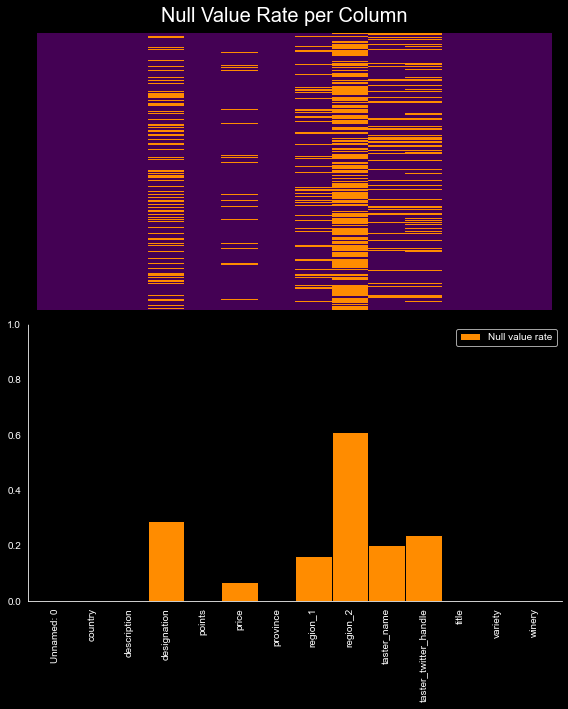

In [124]:
# handle missing values.
# since columns country, province and variety contain fewer missing values, drop the row contains null values.
data = data.dropna(subset=['country', 'province', 'variety'])
nullscan(data, save = True)

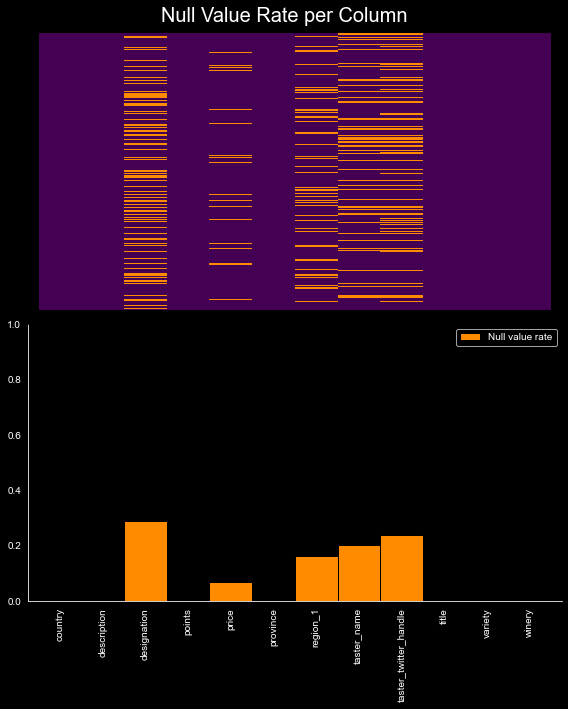

In [125]:
# since column region_2 contains many null values and it doestn't contain important information, drop the column region_2.
data = data.drop('region_2', axis = 1)
data = data.drop('Unnamed: 0', axis = 1)
nullscan(data)

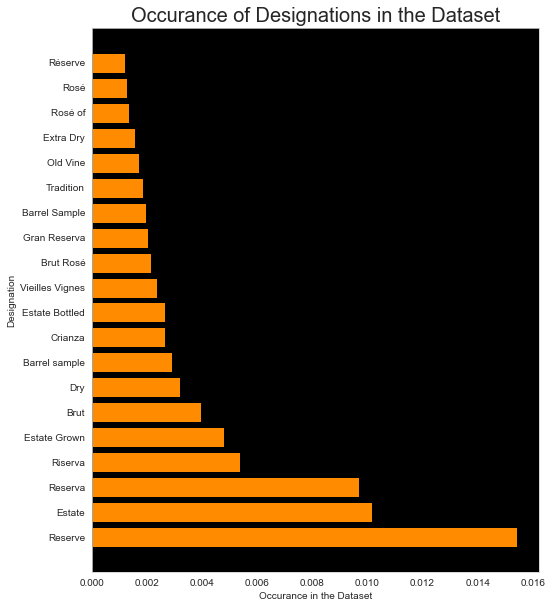

In [126]:
# replace null value with unknown or zero.
# take a look at the column designation.
designation = data['designation'].value_counts().head(20) / len(data.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), sharey=True)
ax.barh(y=designation.index, width=designation.values, color='darkorange', edgecolor='black')
ax.set_title('Occurance of Designations in the Dataset', fontsize=20)
ax.set_xlabel('Occurance in the Dataset')
ax.set_ylabel('Designation')
ax.set_facecolor('black')

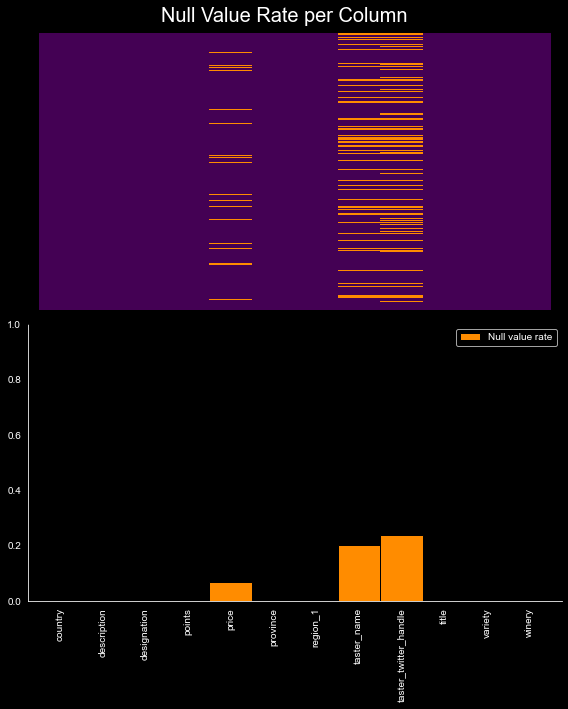

In [127]:
# replace the missing values in column designation and region_1 with 'Unknown'.
data[['designation', 'region_1']] = data[['designation', 'region_1']].fillna('Unknown')
nullscan(data)

In [128]:
# count to see how often a taster name is given but a twitter handle is not.
only_name = data.loc[data['taster_twitter_handle'].isnull() & data['taster_name'].notna(), ['taster_name', 'taster_twitter_handle']]
num_only_name = len(only_name.index)

only_twitter = data.loc[data['taster_name'].isnull() & data['taster_twitter_handle'].notna(), ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)

print(f'Rows that contains a taster name but no twitter handle: {num_only_name}')
print (f'Rows that contains a twitter handle but no taster name: {num_only_twitter}')

Rows that contains a taster name but no twitter handle: 4969
Rows that contains a twitter handle but no taster name: 0


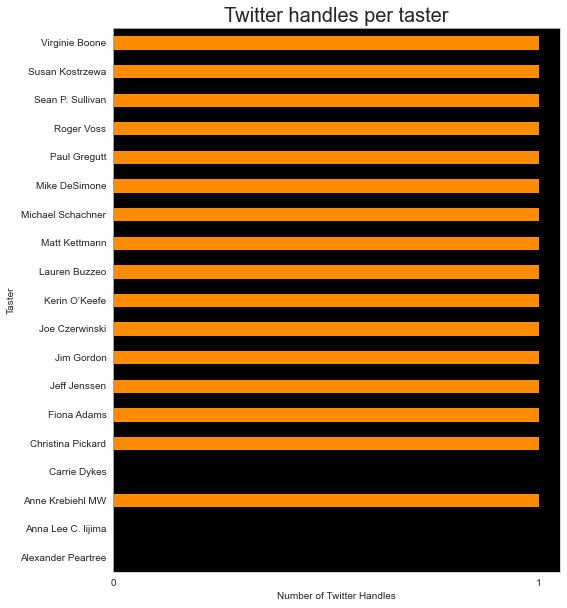

In [129]:
# check if there is any taster that use multiple twitter handles.
twitter_per_name = data.groupby('taster_name')['taster_twitter_handle'].nunique()
labels = twitter_per_name.index


fig, ax = plt.subplots(figsize=(8,10))
twitter_per_name.plot(kind='barh', ax=ax, color='darkorange', edgecolor='black')
ax.set_xticks([0,1])
ax.set_xlabel('Number of Twitter Handles')
ax.set_ylabel('Taster')
ax.set_title('Twitter handles per taster', fontsize=20)
ax.set_facecolor('black')

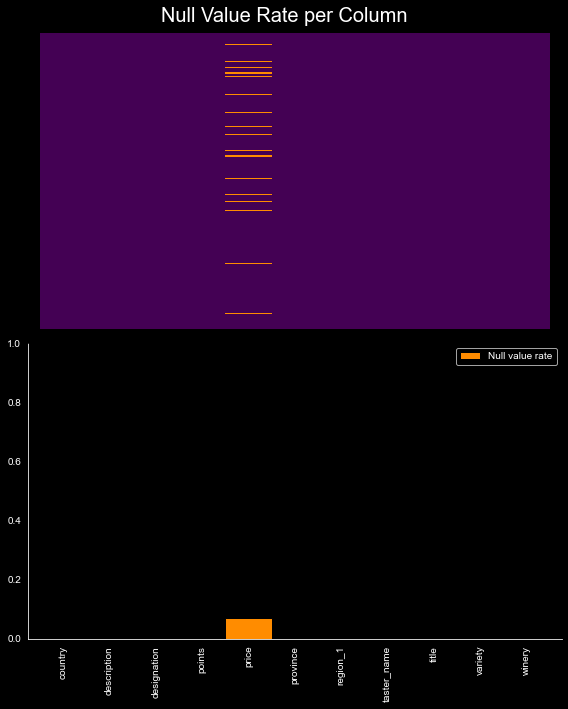

In [130]:
# drop the column taster_twitter_handle, and replace the missing values in column taster_name with Unknown.
data = data.drop('taster_twitter_handle', axis=1)
data['taster_name'] = data['taster_name'].fillna('Unknown')
nullscan(data)

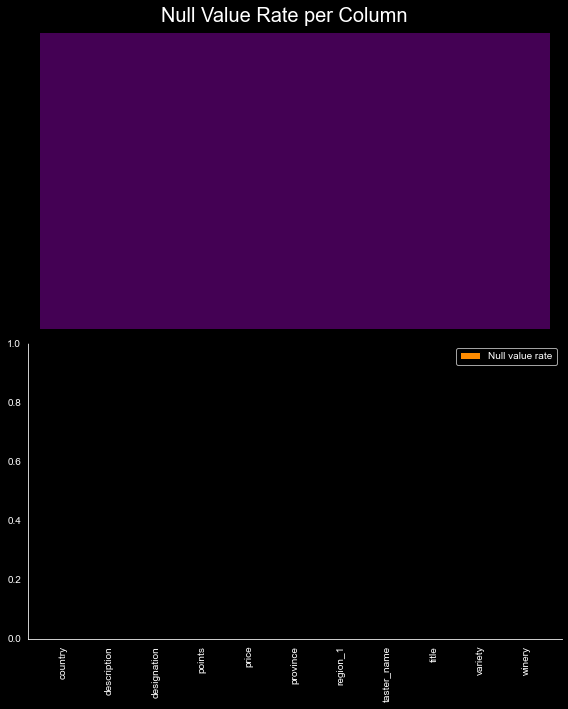

In [131]:
data['price'].fillna(data['price'].dropna().median(),inplace =True)
nullscan(data)

In [132]:
# remove duplicates.
data.duplicated().sum()

9979

In [136]:
data[data.duplicated(['description','title'])].shape[0]

0

In [138]:
data = data.drop_duplicates(['description','title'])

In [140]:
data.to_csv('cleaned-winemag-data-130k-v2.csv')